## **Image Classification Workflow Using CIFAR-10 Dataset**

Proyek ini bertujuan untuk membangun model klasifikasi gambar menggunakan dataset CIFAR-10 dengan pendekatan berbasis Convolutional Neural Network (CNN). Workflow mencakup preprocessing data, augmentasi, fine-tuning model pra-latih (MobileNetV2), pelatihan model dengan callback, evaluasi performa, visualisasi hasil, dan penyimpanan model dalam berbagai format. Proyek ini dirancang agar dapat digunakan pada perangkat dengan resource terbatas maupun aplikasi web berbasis TensorFlow.js

### **Import dan Setup**

In [ ]:
# Import dan Setup
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2  # # OpenCV digunakan untuk transformasi khusus
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

### **Muat Dataset dan Normalisasi**

In [ ]:
# Muat Dataset CIFAR-10
# Dataset CIFAR-10 terdiri dari 50.000 gambar untuk pelatihan dan 10.000 gambar untuk pengujian.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalisasi nilai piksel ke rentang [0,1]
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### **Pembagian Data dan Pra-pemrosesan Label**

In [ ]:
# Pembagian Data - Buat Set Validasi dari Data Pelatihan
# Pisahkan 20% data pelatihan untuk validasi
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

from tensorflow.keras.utils import to_categorical

# Konversi label ke encoding one-hot
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Print shapes untuk verifikasi
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")


y_train shape: (40000, 10)
y_val shape: (10000, 10)
y_test shape: (10000, 10)


### **Transformasi Resolusi Acak**

In [ ]:
import numpy as np
import cv2  # OpenCV diperlukan untuk mengubah ukuran gambar

def random_resolution_transform(image):
    """
    Mensimulasikan resolusi tidak seragam dengan mengubah ukuran gambar secara acak.
    Gambar akan ditambahkan padding atau di-crop kembali menjadi ukuran 32x32.
    """
    # Konversi gambar dari float32 [0,1] ke uint8 [0,255] untuk operasi OpenCV
    image = (image * 255).astype(np.uint8)

    # Skala ukuran gambar secara acak antara 80% dan 120% dari ukuran asli
    scale = np.random.uniform(0.8, 1.2)
    new_size = int(round(32 * scale))

    # Ubah ukuran gambar menggunakan OpenCV
    resized = cv2.resize(image, (new_size, new_size), interpolation=cv2.INTER_LINEAR)

    # Jika ukuran gambar yang diubah lebih kecil dari 32x32, tambahkan padding
    if new_size < 32:
        pad_top = (32 - new_size) // 2
        pad_bottom = 32 - new_size - pad_top
        pad_left = (32 - new_size) // 2
        pad_right = 32 - new_size - pad_left
        resized = cv2.copyMakeBorder(resized, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_REFLECT)
    # Jika ukuran gambar yang diubah lebih besar dari 32x32, lakukan cropping
    elif new_size > 32:
        start = (new_size - 32) // 2
        resized = resized[start:start+32, start:start+32]

    # Konversi kembali ke float32 [0,1]
    return resized.astype(np.float32) / 255.0


### **Augmentasi Data dan Pembuatan Generator Batch**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentasi Data dengan preprocessing khusus
train_datagen = ImageDataGenerator(
    preprocessing_function=random_resolution_transform,  # Apply resolusi non-uniform
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Hasilkan batch data pelatihan dan validasi
train_generator = train_datagen.flow(x_train, y_train, batch_size=64)

# Generator data validasi (tanpa augmentasi)
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(x_val, y_val, batch_size=64)


### **Load Pre-Trained Model dan Konfigurasi Fine-Tuning**

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Muat MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32,32,3))

# Freeze sebagian besar layers (kecuali beberapa lapisan terakhir untuk fine-tuning)
for layer in base_model.layers[:-20]:  # Biarkan 20 lapisan terakhir dapat dilatih
    layer.trainable = False


<ipython-input-6-09a7e1990540>:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32,32,3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### **Bangun Model CNN dengan Arsitektur Berlapis**

In [ ]:
# Bangun CNN Menggunakan Sequential, Conv2D, Pooling (dan lainnya)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

# Definisikan model
model = Sequential([
    # Blok 1
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(32,32,3)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    # Blok 2
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    # Blok 3
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling2D(),  # Mencegah pengurangan dimensi yang berlebihan
    Dropout(0.25),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Lapisan output untuk 10 kelas
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### **Kompilasi Model**

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


### **Pengaturan Learning Rate dengan Callback Scheduler**

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Definisikan fungsi pengaturan learning rate
def lr_schedule(epoch):
    return 1e-3 * (0.95 ** epoch)  # Secara bertahap mengurangi learning rate sebesar 5% setiap epoch

# Buat LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)


### **Augmentasi Data dan Pembuatan Generator Batch**

In [ ]:
# Augmentasi Data
# Membuat ImageDataGenerator yang menerapkan transformasi resolusi
# tidak seragam bersama augmentasi umum lainnya
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
train_generator = train_datagen.flow(x_train, y_train, batch_size=64)


# Untuk set validasi, tidak menerapkan augmentasi tambahan
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(x_val, y_val, batch_size=64)

### **Pelatihan Model dengan Callback dan Evaluasi**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

# Definisikan pengaturan learning rate
def lr_schedule(epoch):
    return 1e-3 * (0.95 ** epoch)  # Decrease learning rate by 5% per epoch

lr_scheduler = LearningRateScheduler(lr_schedule)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    lr_scheduler
]

history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=callbacks
)

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 1200s 2s/step - accuracy: 0.2992 - loss: 2.2275 - val_accuracy: 0.4008 - val_loss: 1.8038 - learning_rate: 0.0010
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 1195s 2s/step - accuracy: 0.5434 - loss: 1.3024 - val_accuracy: 0.5802 - val_loss: 1.3220 - learning_rate: 9.5000e-04
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 1173s 2s/step - accuracy: 0.6357 - loss: 1.0308 - val_accuracy: 0.6576 - val_loss: 0.9473 - learning_rate: 9.0250e-04
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 1155s 2s/step - accuracy: 0.6909 - loss: 0.8871 - val_accuracy: 0.6299 - val_loss: 1.2491 - learning_rate: 8.5737e-04
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 1168s 2s/step - accuracy: 0.7363 - loss: 0.7582 - val_accuracy: 0.6383 - val_loss: 1.2406 - learning_rate: 8.1451e-04
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 1221s 2s/step - accuracy: 0.7559 - loss: 0.7107 - val_accuracy: 0.7611 - val_loss: 0.7645 - learning_rate: 7.7378e-04
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 1177s 2s/step - accuracy: 0

### **Visualisasi Kinerja Model**

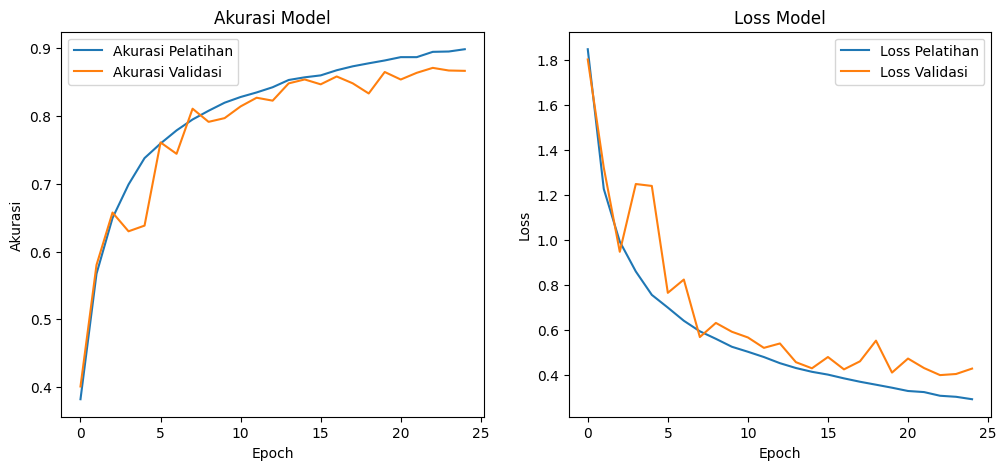

In [ ]:
# Plot Akurasi dan Loss Model
plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### **Simpan dan Konversi Model ke Berbagai Format**

In [ ]:
# Simpan Model dalam Tiga Format
#
# Simpan dalam format TensorFlow SavedModel.
import tensorflow as tf

tf.saved_model.save(model, "saved_model_dir")
print("Model disimpan dalam format SavedModel.")

# Konversi dan simpan model sebagai model TF-Lite.
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model_dir")
tflite_model = converter.convert()

# Save as a .tflite file
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model converted and saved in TF-Lite format.")

# Konversi ke format TensorFlow.js
# Install TensorFlow.js if not already installed
!pip install tensorflowjs

# Convert the model to TensorFlow.js format
!tensorflowjs_converter --input_format=tf_saved_model saved_model_dir tfjs_model_dir

print("Model converted and saved in TensorFlow.js format.")



Model disimpan dalam format SavedModel.
Model converted and saved in TF-Lite format.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-04-26 00:12:27.699049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745626347.740037  124184 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to r

In [ ]:
from google.colab import files

# Compress SavedModel directory into a zip file
!zip -r saved_model_dir.zip saved_model_dir

# Download the compressed SavedModel directory
files.download("saved_model_dir.zip")

# Download TF-Lite model
files.download("model.tflite")

# Compress TensorFlow.js directory into a zip file
!zip -r tfjs_model_dir.zip tfjs_model_dir

# Download the compressed TensorFlow.js directory
files.download("tfjs_model_dir.zip")


updating: saved_model_dir/ (stored 0%)
updating: saved_model_dir/saved_model.pb (deflated 89%)
updating: saved_model_dir/fingerprint.pb (stored 0%)
updating: saved_model_dir/assets/ (stored 0%)
updating: saved_model_dir/variables/ (stored 0%)
updating: saved_model_dir/variables/variables.index (deflated 72%)
updating: saved_model_dir/variables/variables.data-00000-of-00001 (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

updating: tfjs_model_dir/ (stored 0%)
updating: tfjs_model_dir/group1-shard2of2.bin (deflated 7%)
updating: tfjs_model_dir/model.json (deflated 93%)
updating: tfjs_model_dir/group1-shard1of2.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>